# Sensitivity analysis

In [13]:
from SALib.sample import saltelli, fast_sampler
from SALib.sample import ff as ffs
from SALib.analyze import sobol, fast, ff
from SALib.plotting.bar import plot as barplot
import numpy as np
import pandas as pd
import os
import shutil
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


# # image defaults
# import plotly.io as pio
# pio.kaleido.scope.default_format = "pdf"
# pio.kaleido.scope.default_scale = 0.3
# pio.kaleido.scope.default_height = 400
# pio.kaleido.scope.default_width = 500

# function for reading csv files
def pd_read_pattern(pattern, sep):
    files = glob.glob(pattern)
    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f, sep=sep))
    return df.reset_index(drop=True)

# function to remove files
def removeFiles(pattern):
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except:
            print("Error while deleting file : ", file)

# read output files
def readOutput(read_raw_files, path, output_path, result_file_name):
    if (read_raw_files):
        df = pd_read_pattern(path + "group*.csv", sep=";")
        params = pd_read_pattern(path + "par*.csv", sep=";")
        params = params.drop(columns=["replicate"])
        df.iteration = df.iteration.astype(float)
        df = df.sort_values(by=['iteration'])
        df = pd.merge(df, params, on="iteration")
        df.to_csv(output_path + result_file_name + ".csv", index=False)
    else:
        df = pd.read_csv(output_path + result_file_name + ".csv")
    
    return df
        

In [11]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'leakage', 'fertility'],
    'bounds': [[0, 0.75],
               [0, 0.50],
               [0, 0.30]]
}

# Sobol

In [3]:
sample_parameters = False
if (sample_parameters):
    param_values = saltelli.sample(problem, 2**11)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-sobol.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-sobol.csv")
len(t)

16384

In [4]:
df = readOutput(True, "../models/fertility-BMI/output/", "../output/data/", 
    "results-sobol")
# select valid iterations
df = df.loc[df["iteration"] <= len(t),:]
# define outcome
Y = df.g4.to_numpy()
len(Y)

16384

In [5]:
Si = sobol.analyze(problem, Y, print_to_console=True)

                     ST   ST_conf
random-mating  0.250533  0.044973
leakage        0.826616  0.069238
fertility      0.455931  0.077074
                     S1   S1_conf
random-mating  0.009484  0.023524
leakage        0.490007  0.079566
fertility      0.200697  0.038218
                                  S2   S2_conf
(random-mating, leakage)    0.061138  0.070585
(random-mating, fertility) -0.016027  0.044805
(leakage, fertility)        0.087872  0.135700


In [6]:
total, first, second = Si.to_df()

'../manuscript/plots/sobol-s2.pdf'

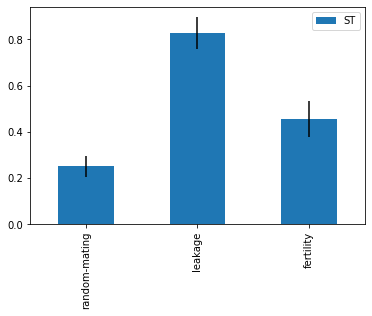

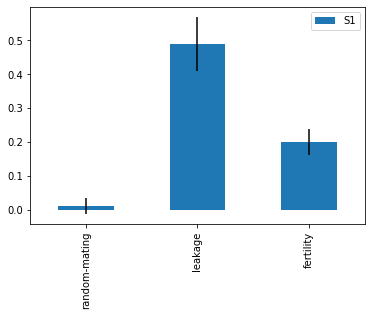

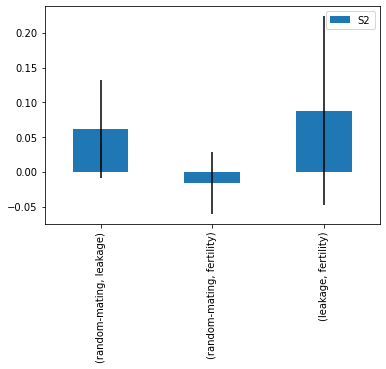

In [7]:
st = barplot(total)
plt.savefig("../output/plots/sobol-st.pdf", bbox_inches='tight')
shutil.copy("../output/plots/sobol-st.pdf", "../manuscript/plots/")
s1 = barplot(first)
plt.savefig("../output/plots/sobol-s1.pdf", bbox_inches='tight')
shutil.copy("../output/plots/sobol-s1.pdf", "../manuscript/plots/")
s2 = barplot(second)
plt.savefig("../output/plots/sobol-s2.pdf", bbox_inches='tight')
shutil.copy("../output/plots/sobol-s2.pdf", "../manuscript/plots/")

In [8]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.4),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=10, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [9]:
fig.write_image("../output/plots/3D-scatter-sobol.pdf")
shutil.copy("../output/plots/3D-scatter-sobol.png", "../manuscript/plots/")

'../manuscript/plots/3D-scatter-sobol.png'

# EFast

In [3]:

sample_parameters = False

if (sample_parameters):
    param_values = fast_sampler.sample(problem, 1000)
    t = pd.DataFrame(param_values)
    t.columns = ["random-mating", "leakage", "fertility"]
    t.to_csv("../models/fertility-BMI/data/param-efast.csv", index=False)
else:
    t = pd.read_csv("../models/fertility-BMI/data/param-efast.csv")

In [5]:
df = readOutput(False, "../models/fertility-BMI/output/", "../output/data/", 
    "results-efast")
df = df.loc[df["iteration"] <= len(t),:]
Y = df["g4"].to_numpy()
len(Y)

3000

In [6]:
df.g4.describe()

count    3000.000000
mean        0.307945
std         0.119986
min         0.000000
25%         0.235237
50%         0.281173
75%         0.348555
max         0.970085
Name: g4, dtype: float64

In [7]:
Sif = fast.analyze(problem, Y, print_to_console=True)

                     S1        ST   S1_conf   ST_conf
random-mating  0.001316  0.210782  0.008395  0.026166
leakage        0.450865  0.769159  0.008661  0.026709
fertility      0.194118  0.450703  0.007000  0.026286


'../manuscript/plots/efast.pdf'

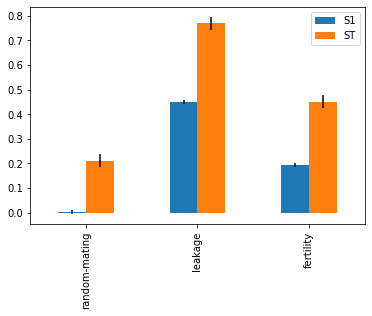

In [8]:
Sif.plot()
plt.savefig("../output/plots/efast.pdf", bbox_inches='tight')
shutil.copy("../output/plots/efast.pdf", "../manuscript/plots/")

In [9]:
fig = px.scatter_3d(df, x='random_mating', y='fertility_factor', z='leakage',
              color='g4', color_continuous_scale = px.colors.sequential.OrRd)

fig.update_traces(marker=dict(size=4, opacity = 0.7),
                  selector=dict(mode='markers'))
fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10), 
                    coloraxis_colorbar=dict(title="Obese")
                    )
fig.show()

In [10]:
#fig.write_image("../output/plots/3D-scatter-efast.pdf")
shutil.copy("../output/plots/3D-scatter-efast.png", "../manuscript/plots/")

'../manuscript/plots/3D-scatter-efast.png'